In [1]:
import sqlite3 as sql
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn import metrics
from xgboost import XGBClassifier
from sklearn.metrics import make_scorer, accuracy_score

In [2]:
conn = sql.connect('db.sqlite')
cards = pd.read_sql_query("SELECT * FROM cards", conn)

customers = pd.read_sql_query("SELECT * FROM customers", conn)

transactions = pd.read_sql_query("SELECT * FROM transactions", conn)

CBtransactions = pd.read_excel("Processing Report.xlsx")

In [3]:
CBARN = []
for row in CBtransactions["ARN"]:
    CBARN.append(row)

mask = transactions['acq_tid'].isin(CBARN)
CBtransactionsMatched = transactions[mask]


TransactionsBeforeNewVal = CBtransactionsMatched["cb"]
TransactionsAfterNewVal = TransactionsBeforeNewVal.replace([0],"1")
CBtransactionsMatched["cb"] = 1
CBtransactionsMatched

transactions.update(CBtransactionsMatched)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


In [9]:
CardsToAnalysis = cards[["id","brand","bin_country"]]
transactionsEXT = pd.merge(transactions, CardsToAnalysis, left_on='card_id', right_on ="id", how='left')

In [5]:
Data = transactionsEXT[["amount","currency","brand","bin_country"]]
y = transactionsEXT["cb"]

encoder = OneHotEncoder(sparse=False)
ToEncode = Data[["currency","brand","bin_country"]]
DataEncoded = encoder.fit_transform(ToEncode)

colnames = []
for cat in encoder.categories_[0]:
    colnames.append(f'currency_{cat}')
for cat in encoder.categories_[1]:
    colnames.append(f'brand_{cat}')
for cat in encoder.categories_[2]:
    colnames.append(f'bin_country_{cat}')


EncodedX = pd.DataFrame(DataEncoded, columns= colnames)
EncodedX["amount"] = transactions["amount"]
X = EncodedX


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

accuracy of model is  0.9942676984809401


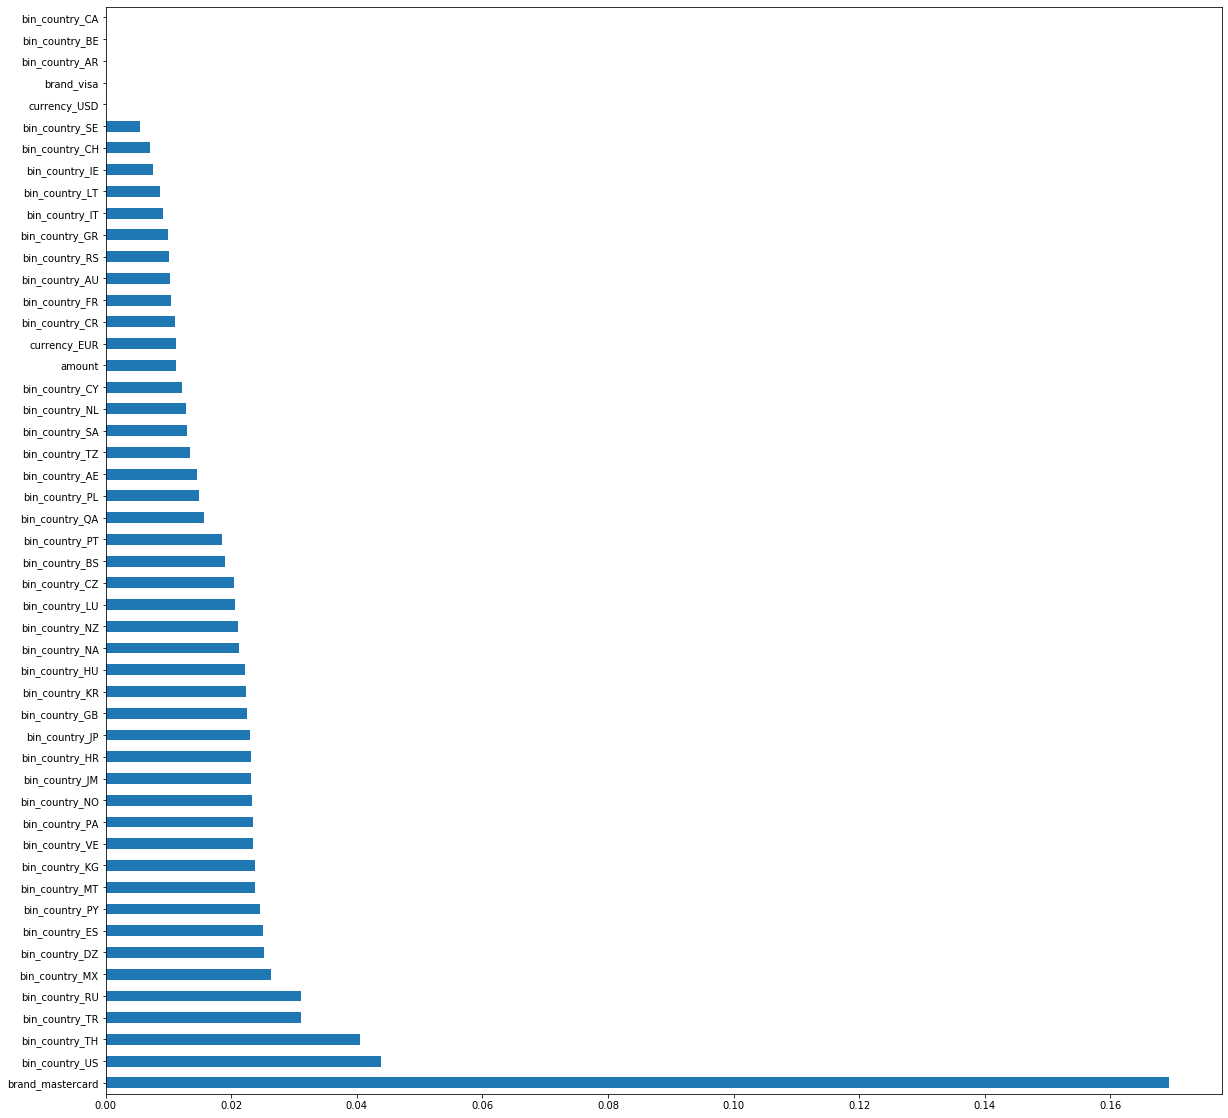

In [10]:

XGB = XGBClassifier()
XGB.fit(X_train, y_train)

XGBpred = XGB.predict(X_test)
predictions = [round(value) for value in XGBpred]
accuracy = accuracy_score(y_test, predictions)
print("accuracy of model is ",accuracy)

plt.rcParams["figure.figsize"] = (20,20)
feat_importances = pd.Series(XGB.feature_importances_, index=X.columns)
feat_importances.nlargest(50).plot(kind='barh')


In [13]:
print(CBtransactionsMatched.describe(),CBtransactionsMatched.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 193 entries, 100 to 34701
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   id          193 non-null    int64 
 1   created_at  193 non-null    object
 2   succes      193 non-null    int64 
 3   amount      193 non-null    int64 
 4   currency    193 non-null    object
 5   acq_tid     193 non-null    object
 6   card_id     193 non-null    int64 
 7   cb          193 non-null    int64 
dtypes: int64(5), object(3)
memory usage: 18.6+ KB
                 id  succes       amount       card_id     cb
count  1.930000e+02   193.0   193.000000  1.930000e+02  193.0
mean   1.510689e+09     1.0  1481.865285  1.500497e+09    1.0
std    2.350011e+06     0.0   795.385548  9.202994e+06    0.0
min    1.506900e+09     1.0   200.000000  1.483502e+09    1.0
25%    1.508693e+09     1.0   800.000000  1.494146e+09    1.0
50%    1.510854e+09     1.0  1400.000000  1.501761e+09    1.0
75%    

In [16]:
CBtransactionsEXT = pd.merge(CBtransactionsMatched, CardsToAnalysis, left_on='card_id', right_on ="id", how='left')
CBcurrencyFrequency = CBtransactionsEXT["currency"].value_counts()
CBbrandFrequency = CBtransactionsEXT["brand"].value_counts() 
CBcountryFrequency = CBtransactionsEXT["bin_country"].value_counts() 
display(CBcurrencyFrequency,CBbrandFrequency,CBcountryFrequency)

EUR    100
USD     93
Name: currency, dtype: int64

visa    193
Name: brand, dtype: int64

US    40
TH    23
RU    19
TR    16
NO     9
CR     6
LT     5
CY     5
PT     5
SA     4
AU     4
FR     4
HU     4
PL     4
NL     4
TZ     3
KW     3
RS     3
IE     3
QA     3
CH     2
IL     2
GR     2
LU     2
IT     2
CL     1
JP     1
AE     1
KG     1
DE     1
VE     1
SE     1
MX     1
PY     1
JM     1
AR     1
NA     1
ES     1
CA     1
BE     1
BS     1
Name: bin_country, dtype: int64

In [ ]:
zapytaj na kursie o ficzery,procent kart zarejestrowanych w kraju które mialy cb, procent waluty,problem tylko visa,